# Boosting but not with CNNs as weak learners but by first extracting features by cnns and then applying boosting with trees
We already saw for random forests that the MobileNetV3 model for the feature exraction worked well, so we use this here.

We use XGBoost to perform the boosting 

In [5]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision import datasets, models, transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
from xgboost import XGBClassifier

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#from the code by Hishem
def load_mri_data(base_path, batch_size=32):
    train_dir = os.path.join(base_path, 'Training')
    test_dir = os.path.join(base_path, 'Testing')

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    total_dataset = ConcatDataset([train_dataset, test_dataset])
    labels_map = {0: 'glioma tumor', 1: 'meningioma tumor', 2: 'no tumor', 3: 'pituitary tumor'}
    return total_dataset, labels_map

def prepare_data_loader(dataset, test_fraction=0.2, batch_size=32):
    total_size = len(dataset)
    test_size = int(total_size * test_fraction)
    train_size = total_size - test_size

    random_seed = 42
    generator = torch.Generator().manual_seed(random_seed)

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader


# now my code:

def extract_features(model, dataloader):
    model.eval()  # evaluation mode
    features_list = []
    labels_list = []

    with torch.no_grad(): # leave out gradient computation in the loop → less computational memory
        for inputs, labels in tqdm(dataloader, desc="Extracting features"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # flatten features from (batch_size, channels, height, width) to (batch_size, channels*height*width)
            features_flatten = outputs.view(outputs.size(0), -1)
            features_list.extend(features_flatten.cpu().numpy()) #first move features to cpu so that numpy can use it
            labels_list.extend(labels.cpu().numpy())
    
    return np.array(features_list), np.array(labels_list)

def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(6, 4))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    # annotate the cells with the relative values 
    norm_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f'{norm_conf_matrix[i, j]:.2f}', horizontalalignment="center",
                     color="white" if norm_conf_matrix[i, j] > 0.5 else "black")
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

In [6]:
def evaluate_single_hyperparameter_n_estimators(train_index, val_index, n_estimators, X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    xgb_classifier = XGBClassifier(n_estimators=n_estimators, random_state=42, eval_metric='logloss')
    xgb_classifier.fit(X_train_fold, y_train_fold)
    val_preds = xgb_classifier.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, val_preds)
    
    return val_accuracy

def evaluate_hyperparameters_n_estimators(X_train, y_train, n_estimators_list, n_splits=5, n_jobs=-1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = [[] for _ in range(len(n_estimators_list))]

    # with tqdm for progress bar
    for train_index, val_index in tqdm(skf.split(X_train, y_train), total=n_splits, desc="CV Folds"):
        parallel_results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_single_hyperparameter_n_estimators)(train_index, val_index, n_estimators, X_train, y_train)
            for n_estimators in n_estimators_list
        )

        for i, score in enumerate(parallel_results):
            fold_scores[i].append(score)


    mean_cv_scores = [np.mean(scores) for scores in fold_scores]
    return mean_cv_scores



In [7]:
base_path = 'archive/gray_smaller_size/'  
batch_size = 32
total_dataset, labels_map = load_mri_data(base_path, batch_size=batch_size)
train_loader, test_loader = prepare_data_loader(total_dataset, test_fraction=0.2, batch_size=batch_size)

In [8]:
# loadpretrained MobileNetV3 model
model = models.mobilenet_v3_large(pretrained=True)
# remove the last classification layer to get feature extractor
model = torch.nn.Sequential(*(list(model.children())[:-1]), torch.nn.AdaptiveAvgPool2d((1, 1))).to(device)

# extract features using the pretrained model
X_train, y_train = extract_features(model, train_loader)
X_test, y_test = extract_features(model, test_loader)

/home/vm/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vm/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features: 100%|██████████████████████| 43/43 [00:40<00:00,  1.07it/s]


In [ ]:
n_estimators_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]

# Perform cross-validation to evaluate different n_estimators
mean_cv_scores = evaluate_hyperparameters_n_estimators(X_train, y_train, n_estimators_values, n_jobs=-1)

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(n_estimators_values, mean_cv_scores, label='Mean CV Accuracy', marker='o', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs n_estimators in XGBoost')
plt.legend() 
plt.grid(True)
plt.show()

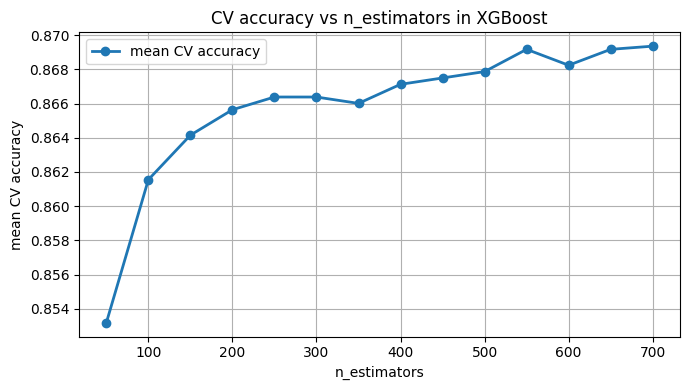

In [7]:

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(n_estimators_values, mean_cv_scores, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs n_estimators in XGBoost')
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.savefig('CV_boost_estimators_upto700')
np.save('700n_estimators_values.npy', n_estimators_values)
np.save('700mean_cv_scores.npy', mean_cv_scores)
plt.show()

In [8]:
n_estimators_values700 = n_estimators_values
mean_cv_scores700 = mean_cv_scores

## now for even more

CV Folds: 100%|████████████████████████████████| 5/5 [1:09:47<00:00, 837.41s/it]


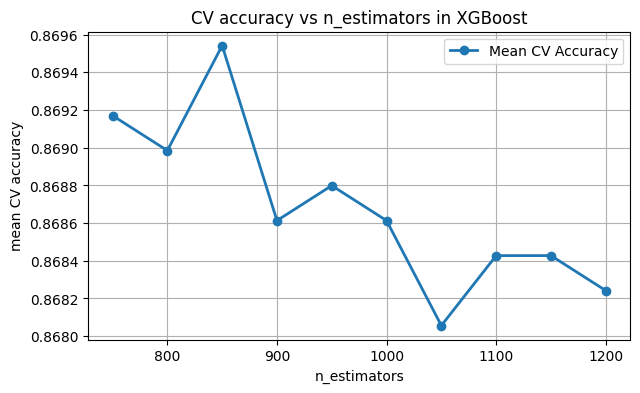

In [13]:
n_estimators_values = [750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200]

# Perform cross-validation to evaluate different n_estimators
mean_cv_scores = evaluate_hyperparameters_n_estimators(X_train, y_train, n_estimators_values, n_jobs=-1)

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(n_estimators_values, mean_cv_scores, label='Mean CV Accuracy', marker='o', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs n_estimators in XGBoost')
plt.legend() 
plt.grid(True)
plt.show()

In [14]:
np.save('700-1200n_estimators_values.npy', n_estimators_values)
np.save('700-1200mean_cv_scores.npy', mean_cv_scores)

In [15]:
n_estimators_values7501200 = n_estimators_values
mean_cv_scores7501200 = mean_cv_scores

In [16]:
n_estimators_values = n_estimators_values700 + n_estimators_values7501200
mean_cv_scores = mean_cv_scores700 + mean_cv_scores7501200

np.save('alln_estimators_values.npy', n_estimators_values)
np.save('allmean_cv_scores.npy', mean_cv_scores)

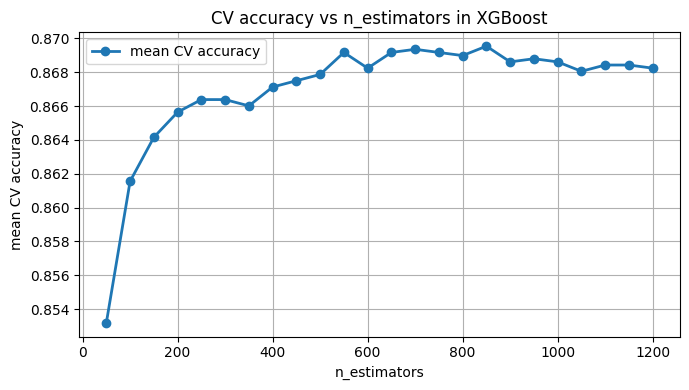

In [17]:
# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(n_estimators_values, mean_cv_scores, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs n_estimators in XGBoost')
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.savefig('CV_boost_estimators_upto1200')
plt.show()

As a result we choose 700 estimators. seems to overfit a bit afterwards.

In [ ]:
TODOOO ANDERE HYPERPARAMETER AUSCHECKEN:::: WAS MACHT XGBOOST JETZT WIIIRKLICH

In [18]:
# Find the optimal n_estimators value
optimal_n_estimators = n_estimators_values[np.argmax(mean_cv_scores)]
print(f"Optimal n_estimators: {optimal_n_estimators}")

Optimal n_estimators: 850


In [ ]:
# Train the final model with 700 estimators
xgb_classifier = XGBClassifier(n_estimators=700, random_state=42, eval_metric='logloss')
xgb_classifier.fit(X_train, y_train)

# Predictions on training set and test set
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)

Training Accuracy: 1.0000
Testing Accuracy: 0.8855

Confusion Matrix (Test Data):
 [[267  42   4  10]
 [ 27 267  16  27]
 [  5   8 329   3]
 [  2   9   1 328]]

Classification Report:
                   precision    recall  f1-score   support

    glioma tumor       0.89      0.83      0.86       323
meningioma tumor       0.82      0.79      0.81       337
        no tumor       0.94      0.95      0.95       345
 pituitary tumor       0.89      0.96      0.93       340

        accuracy                           0.89      1345
       macro avg       0.88      0.88      0.88      1345
    weighted avg       0.88      0.89      0.88      1345



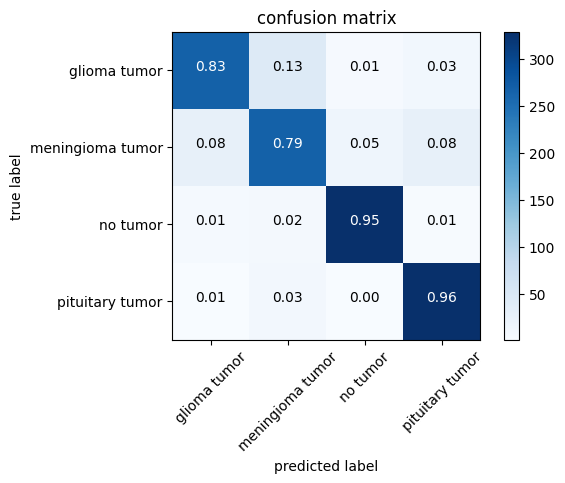

In [22]:
# Calculate Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Confusion Matrices and Classification Report
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, target_names=labels_map.values())

print("\nConfusion Matrix (Test Data):\n", test_conf_matrix)
print("\nClassification Report:\n", class_report)

plot_confusion_matrix(test_conf_matrix, labels_map.values())

get accuracy for test data of 88.55%, but still overfitting

## now tune hyperparamter for L2 regularization 

In [23]:
def evaluate_single_hyperparameter_lambdareg(train_index, val_index, lamb, X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    xgb_classifier = XGBClassifier(n_estimators=700, random_state=42, eval_metric='logloss', reg_lambda = lamb)
    xgb_classifier.fit(X_train_fold, y_train_fold)
    val_preds = xgb_classifier.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, val_preds)
    
    return val_accuracy

def evaluate_hyperparameters_lambdareg(X_train, y_train, lambdas, n_splits=5, n_jobs=-1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = [[] for _ in range(len(lambdas))]

    # with tqdm for progress bar
    for train_index, val_index in tqdm(skf.split(X_train, y_train), total=n_splits, desc="CV Folds"):
        parallel_results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_single_hyperparameter_lambdareg)(train_index, val_index, lamb, X_train, y_train)
            for lamb in lambdas
        )

        for i, score in enumerate(parallel_results):
            fold_scores[i].append(score)


    mean_cv_scores = [np.mean(scores) for scores in fold_scores]
    return mean_cv_scores



the default value is 1, so we try larger values to get more regularization

In [ ]:
lambdas = [1, 2, 4, 8, 16, 32]

# Perform cross-validation to evaluate different n_estimators
mean_cv_scores = evaluate_hyperparameters_lambdareg(X_train, y_train, lambdas, n_jobs=-1)



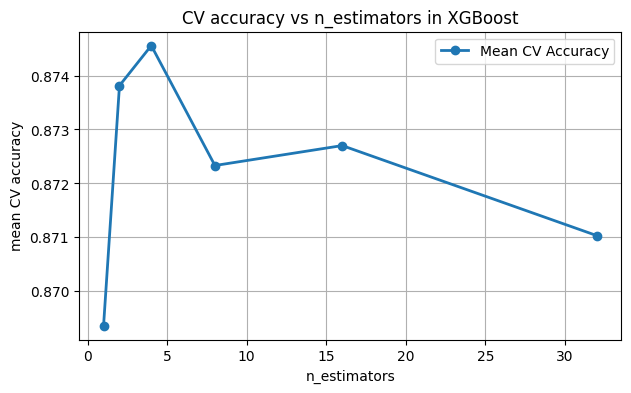

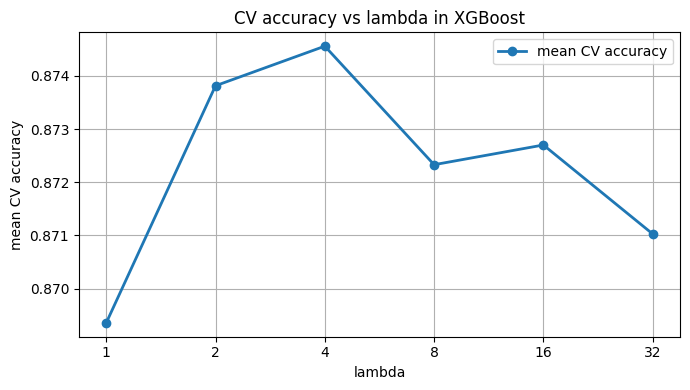

In [27]:

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(lambdas, mean_cv_scores, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('lambda')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs lambda in XGBoost')
plt.legend() 
plt.grid(True)
plt.gca().set_xscale('log', base=2)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.tight_layout()
plt.savefig('CV_boost_lambdas_(lambda_reg)')
np.save('lambdas_values_CV.npy', n_estimators_values)
np.save('mean_cv_scores_lambdas.npy', mean_cv_scores)
plt.show()

best performance for lambda = 4, so we choose this.

In [28]:
# Train the final model with 700 estimators and reg_lambda = 4
xgb_classifier = XGBClassifier(n_estimators=700, random_state=42, eval_metric='logloss', reg_lambda = 4)
xgb_classifier.fit(X_train, y_train)

# Predictions on training set and test set
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)

Training Accuracy: 1.0000
Testing Accuracy: 0.8892

Confusion Matrix (Test Data):
 [[267  43   3  10]
 [ 29 269  17  22]
 [  3   7 331   4]
 [  3   8   0 329]]

Classification Report:
                   precision    recall  f1-score   support

    glioma tumor       0.88      0.83      0.85       323
meningioma tumor       0.82      0.80      0.81       337
        no tumor       0.94      0.96      0.95       345
 pituitary tumor       0.90      0.97      0.93       340

        accuracy                           0.89      1345
       macro avg       0.89      0.89      0.89      1345
    weighted avg       0.89      0.89      0.89      1345



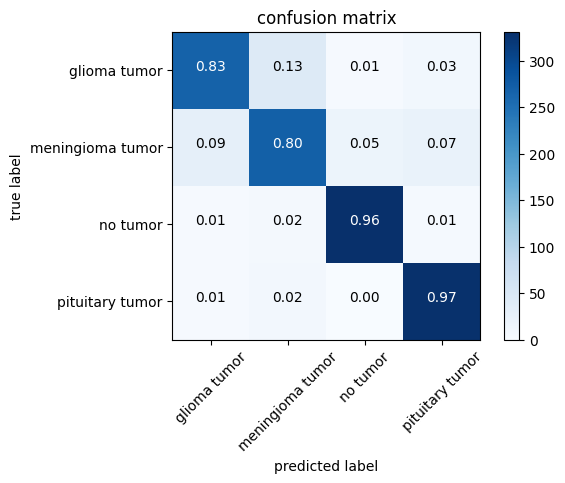

In [29]:
# Calculate Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Confusion Matrices and Classification Report
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, target_names=labels_map.values())

print("\nConfusion Matrix (Test Data):\n", test_conf_matrix)
print("\nClassification Report:\n", class_report)

plot_confusion_matrix(test_conf_matrix, labels_map.values())

## now tune hyperparamter for L1 regularization including the decision for the L2 regularization term

In [9]:
def evaluate_single_hyperparameter_alphareg(train_index, val_index, lamb, X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    xgb_classifier = XGBClassifier(n_estimators=700, random_state=42, eval_metric='logloss', reg_alpha = lamb, reg_lambda=4)
    xgb_classifier.fit(X_train_fold, y_train_fold)
    val_preds = xgb_classifier.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, val_preds)
    
    return val_accuracy

def evaluate_hyperparameters_alphareg(X_train, y_train, lambdas, n_splits=5, n_jobs=-1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = [[] for _ in range(len(lambdas))]

    # with tqdm for progress bar
    for train_index, val_index in tqdm(skf.split(X_train, y_train), total=n_splits, desc="CV Folds"):
        parallel_results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_single_hyperparameter_alphareg)(train_index, val_index, lamb, X_train, y_train)
            for lamb in lambdas
        )

        for i, score in enumerate(parallel_results):
            fold_scores[i].append(score)


    mean_cv_scores = [np.mean(scores) for scores in fold_scores]
    return mean_cv_scores



the default value is 0 so we try larger values to get more regularization

In [ ]:
alphas = [0, 2**(-4), 2**(-3), 2**(-2), 2**(-1), 2**0, 2**1]

# Perform cross-validation to evaluate different n_estimators
mean_cv_scores = evaluate_hyperparameters_alphareg(X_train, y_train, alphas, n_jobs=-1)

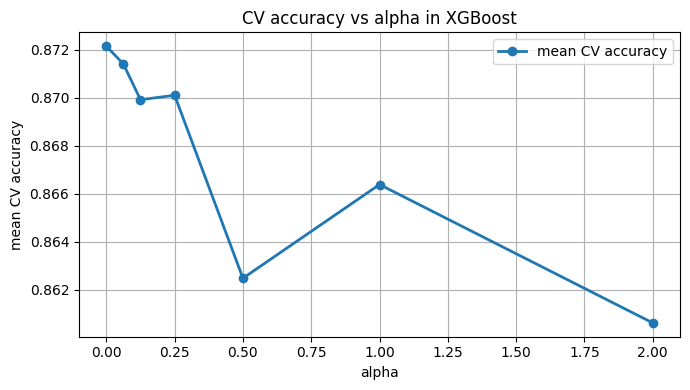

In [16]:

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(alphas, mean_cv_scores, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('alpha')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs alpha in XGBoost')
plt.legend() 
plt.grid(True)
#plt.gca().set_xscale('log', base=2)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.tight_layout()
plt.savefig('CV_boost_alphas_(alpha_reg)')
np.save('alphas_values_CV.npy', alphas)
np.save('mean_cv_scores_alphas.npy', mean_cv_scores)
plt.show()

best performance for alpha = 0 already. so we don't change it

## study min child weight

In [18]:
def evaluate_single_hyperparameter_minchild(train_index, val_index, weight, X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    xgb_classifier = XGBClassifier(n_estimators=700, random_state=42, eval_metric='logloss', reg_alpha = 0, reg_lambda=4, min_child_weight = weight)
    xgb_classifier.fit(X_train_fold, y_train_fold)
    val_preds = xgb_classifier.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, val_preds)
    
    return val_accuracy

def evaluate_hyperparameters_minchild(X_train, y_train, weights, n_splits=5, n_jobs=-1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = [[] for _ in range(len(weights))]

    # with tqdm for progress bar
    for train_index, val_index in tqdm(skf.split(X_train, y_train), total=n_splits, desc="CV Folds"):
        parallel_results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_single_hyperparameter_minchild)(train_index, val_index, weight, X_train, y_train)
            for weight in weights
        )

        for i, score in enumerate(parallel_results):
            fold_scores[i].append(score)


    mean_cv_scores = [np.mean(scores) for scores in fold_scores]
    return mean_cv_scores



In [ ]:
weights = [1, 2, 4, 8, 16]
# Perform cross-validation to evaluate different n_estimators
mean_cv_scores = evaluate_hyperparameters_minchild(X_train, y_train, weights, n_jobs=-1)

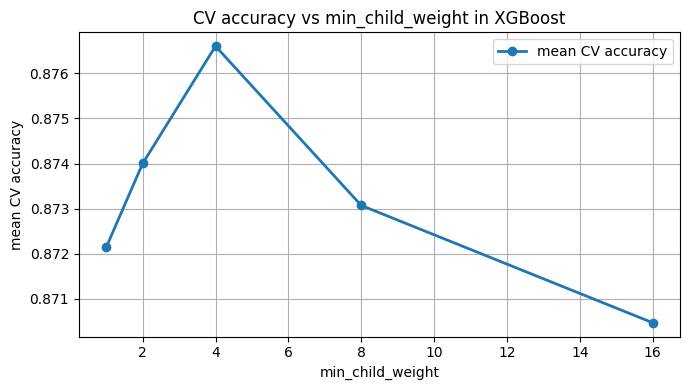

In [20]:

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(weights, mean_cv_scores, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('min_child_weight')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs min_child_weight in XGBoost')
plt.legend() 
plt.grid(True)
#plt.gca().set_xscale('log', base=2)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.tight_layout()
plt.savefig('CV_boost_minchild_(min_child_weight)')
np.save('minchild_values_CV.npy', weights)
np.save('mean_cv_scores_minchild.npy', mean_cv_scores)
plt.show()

As optimal parameter we get the minimum child weight of 4.

## now try again to run CV for the iterations, maybe there is an improvement ?

In [22]:
def evaluate_single_hyperparameter_estim(train_index, val_index, n_estimators, X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    xgb_classifier = XGBClassifier(n_estimators=n_estimators, random_state=42, eval_metric='logloss', reg_alpha = 0, reg_lambda=4, min_child_weight = 4)
    xgb_classifier.fit(X_train_fold, y_train_fold)
    val_preds = xgb_classifier.predict(X_val_fold)
    val_accuracy = accuracy_score(y_val_fold, val_preds)
    
    return val_accuracy

def evaluate_hyperparameters_estim(X_train, y_train, estimator_nums, n_splits=5, n_jobs=-1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = [[] for _ in range(len(estimator_nums))]

    # with tqdm for progress bar
    for train_index, val_index in tqdm(skf.split(X_train, y_train), total=n_splits, desc="CV Folds"):
        parallel_results = Parallel(n_jobs=n_jobs)(
            delayed(evaluate_single_hyperparameter_minchild)(train_index, val_index, n_estimators, X_train, y_train)
            for n_estimators in estimator_nums
        )

        for i, score in enumerate(parallel_results):
            fold_scores[i].append(score)


    mean_cv_scores = [np.mean(scores) for scores in fold_scores]
    return mean_cv_scores



In [ ]:
estimator_nums = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]
# Perform cross-validation to evaluate different n_estimators
mean_cv_scores = evaluate_hyperparameters_estim(X_train, y_train, estimator_nums, n_jobs=-1)

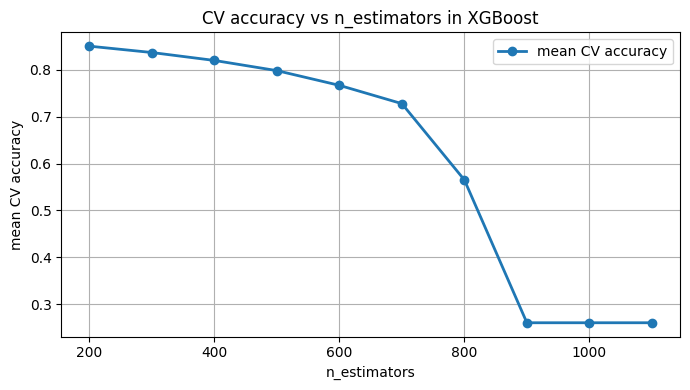

In [24]:

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(estimator_nums, mean_cv_scores, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs n_estimators in XGBoost')
plt.legend() 
plt.grid(True)
#plt.gca().set_xscale('log', base=2)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.tight_layout()
plt.savefig('CV_boost_estimators2_(n_estimators)')
np.save('estimators2_values_CV.npy', estimator_nums)
np.save('mean_cv_scores_estimators2.npy', mean_cv_scores)
plt.show()

surprisingly, fewernumbers of estimators are moresuitable. this however can make sense because we varied many parameters since we first tried to fix the numbers of estimators.

In [25]:
mean_cv_scores_200to1100 = mean_cv_scores

In [ ]:
estimator_nums = [50,100, 150]
# Perform cross-validation to evaluate different n_estimators
mean_cv_scores = evaluate_hyperparameters_estim(X_train, y_train, estimator_nums, n_jobs=-1)

In [27]:
np.save('estimators2uptp150_values_CV.npy', estimator_nums)
np.save('mean_cv_scores_estimators2upto150.npy', mean_cv_scores)

In [28]:
mean_cv_scores_all = mean_cv_scores + mean_cv_scores_200to1100
estimatorss = [50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]

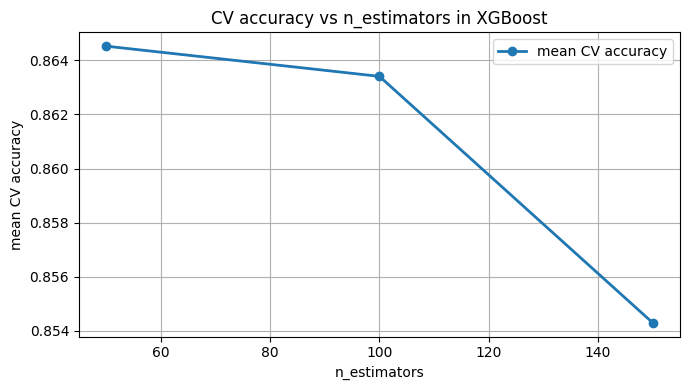

In [29]:

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(estimator_nums, mean_cv_scores, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs n_estimators in XGBoost')
plt.legend() 
plt.grid(True)
#plt.gca().set_xscale('log', base=2)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.tight_layout()
plt.savefig('CV_boost_estimators2_-150_(n_estimators)')
plt.show()

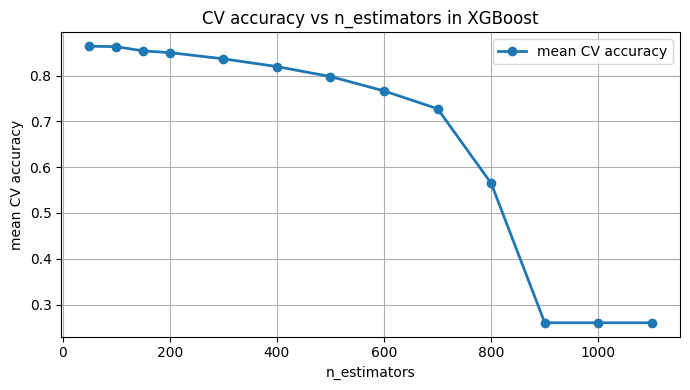

In [30]:

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(estimatorss, mean_cv_scores_all, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs n_estimators in XGBoost')
plt.legend() 
plt.grid(True)
#plt.gca().set_xscale('log', base=2)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.tight_layout()
plt.savefig('CV_boost_estimators2_all_(n_estimators)')
plt.show()

In [31]:
estimator_nums = [10,20,30,40]
# Perform cross-validation to evaluate different n_estimators
mean_cv_scores = evaluate_hyperparameters_estim(X_train, y_train, estimator_nums, n_jobs=-1)

CV Folds: 100%|██████████████████████████████████| 5/5 [14:35<00:00, 175.07s/it]


In [32]:
np.save('estimators2uptp40_values_CV.npy', estimator_nums)
np.save('mean_cv_scores_estimators2upto40.npy', mean_cv_scores)

In [33]:
mean_cv_scores_alle = mean_cv_scores + mean_cv_scores_all
estimatorss_all = estimator_nums + estimatorss

np.save('estimators2_from10to1100_values_CV.npy', estimatorss_all)
np.save('mean_cv_scores_estimators2_from10to1100.npy', mean_cv_scores_alle)

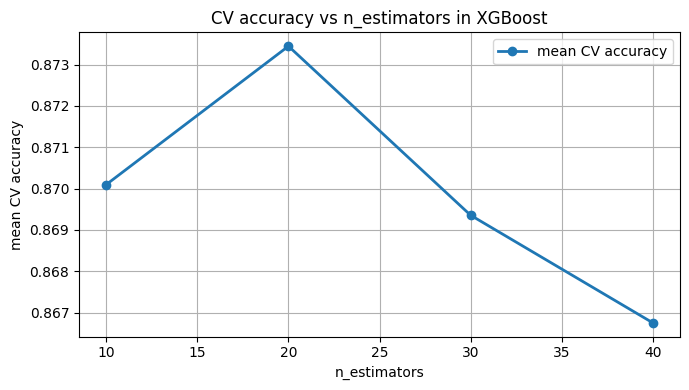

In [34]:

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(estimator_nums, mean_cv_scores, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs n_estimators in XGBoost')
plt.legend() 
plt.grid(True)
#plt.gca().set_xscale('log', base=2)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.tight_layout()
plt.savefig('CV_boost_estimators2_-40_(n_estimators)')
plt.show()

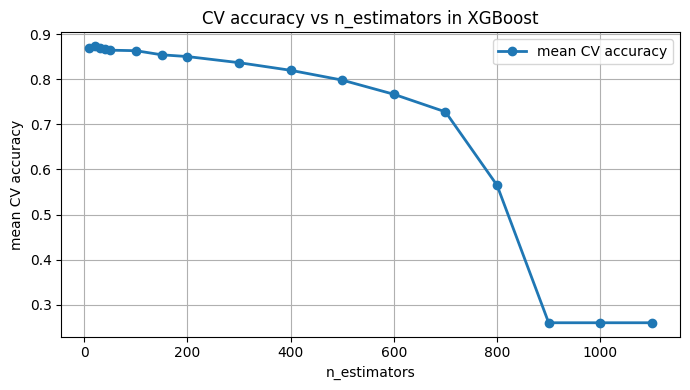

In [35]:

# Plot the results
plt.figure(figsize=(7, 4))
plt.plot(estimatorss_all, mean_cv_scores_alle, label='mean CV accuracy', marker='o', linewidth=2)
plt.xlabel('n_estimators')
plt.ylabel('mean CV accuracy')
plt.title('CV accuracy vs n_estimators in XGBoost')
plt.legend() 
plt.grid(True)
#plt.gca().set_xscale('log', base=2)
#plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
plt.tight_layout()
plt.savefig('CV_boost_estimators2_all_with40_(n_estimators)')
plt.show()

In [42]:
# Train the final model with 700 estimators 
xgb_classifier = XGBClassifier(n_estimators=700, random_state=42, eval_metric='logloss', reg_lambda = 4, reg_alpha=0 , min_child_weight = 4)
xgb_classifier.fit(X_train, y_train)

# Predictions on training set and test set
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)

Training Accuracy: 1.0000
Testing Accuracy: 0.8937

Confusion Matrix (Test Data):
 [[272  41   2   8]
 [ 25 272  17  23]
 [  2   8 331   4]
 [  4   7   2 327]]

Classification Report:
                   precision    recall  f1-score   support

    glioma tumor       0.90      0.84      0.87       323
meningioma tumor       0.83      0.81      0.82       337
        no tumor       0.94      0.96      0.95       345
 pituitary tumor       0.90      0.96      0.93       340

        accuracy                           0.89      1345
       macro avg       0.89      0.89      0.89      1345
    weighted avg       0.89      0.89      0.89      1345



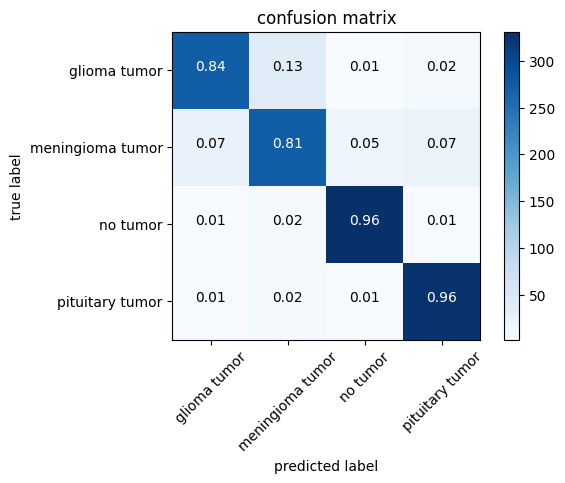

In [43]:
# Calculate Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Confusion Matrices and Classification Report
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, target_names=labels_map.values())

print("\nConfusion Matrix (Test Data):\n", test_conf_matrix)
print("\nClassification Report:\n", class_report)

plot_confusion_matrix(test_conf_matrix, labels_map.values())

In [44]:
# Train the final model with 20 estimators
xgb_classifier = XGBClassifier(n_estimators=20, random_state=42, eval_metric='logloss', reg_lambda = 4, reg_alpha=0 , min_child_weight = 4)
xgb_classifier.fit(X_train, y_train)

# Predictions on training set and test set
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)

Training Accuracy: 0.9978
Testing Accuracy: 0.8468

Confusion Matrix (Test Data):
 [[256  53   2  12]
 [ 46 240  21  30]
 [  1  17 322   5]
 [  4  13   2 321]]

Classification Report:
                   precision    recall  f1-score   support

    glioma tumor       0.83      0.79      0.81       323
meningioma tumor       0.74      0.71      0.73       337
        no tumor       0.93      0.93      0.93       345
 pituitary tumor       0.87      0.94      0.91       340

        accuracy                           0.85      1345
       macro avg       0.84      0.85      0.84      1345
    weighted avg       0.84      0.85      0.85      1345



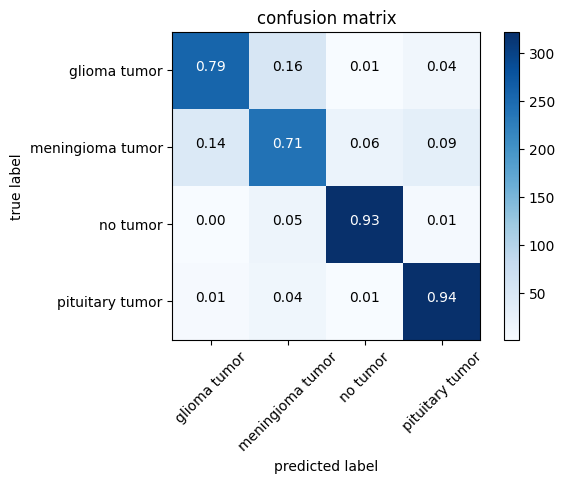

In [45]:
# Calculate Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Confusion Matrices and Classification Report
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred, target_names=labels_map.values())

print("\nConfusion Matrix (Test Data):\n", test_conf_matrix)
print("\nClassification Report:\n", class_report)

plot_confusion_matrix(test_conf_matrix, labels_map.values())

In [46]:
xgb_classifier.objective

'multi:softprob'